# AAAI EM Iteration Notebook

Slightly modified for current system.


---

### Required:
- Tensors:
    - `X_test`: Testing Image Tensor
    - `Y_test`: Testing Label Tensor
    - `X_train`: Training Image Tensor
    - `X_val`: Validation Image Tensor
    - `train_offsets`: Window offsets for scanning `Y_train` as path to csv.
    - `val_offsets`: Window offsets for scanning `Y_val` as path to csv.

- `segments`: Candidate line segments accross training raster in directory

- `preweights`: pre-trained Weights for U-Net model on the passed `X_train`, `X_val` tensors

- `initial_pmap`: pmap output from baseline data

In [1]:
# -- All Imports --
import os, sys, time, csv

import tensorflow as tf
import numpy as np
import random as rand
import geopandas as gpd
import matplotlib.pyplot as plt

from lib.ModuleTools import *
from lib.UnetTools import *
import lib.GeoTools as gt
import lib.ShapeTools as st
import lib.EMTools as emt
import lib.LineGen as lg

# Parameters, Files
from lib.EMconfigScene02 import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# -- Module Information --
module_data = {
    'name': 'EM_Iteration_s02', # Module Name
    'desc': 'Iterate over EM process using the second dataset', # Module Description
    'test_name': 'aaai_emtest_s02', # Default test name
    'csv': 'master_s02.csv', # Csv path
    'verbose': True # Default verbosity
}
test = ModuleTest(module_data)
# -------------------------


# -- Iteration Parameters --
iteration = {}

# Number of EM iterations
EM_target = wrap(2, iteration) 
 
# Constant Value for Learning Rate Schedule 
lr_const = wrap(2, iteration)

# optionally reset layer weights between iterations
rebuild_model = wrap( True, iteration)

# (epsilon) Chance that a candidate will be selected outside of the top candidate, within the K top candidates.
random_candidate_chance = wrap( 0, iteration)

# (K) Consider K top-weighted segments. set 1 for top candidate, set 0 to consider all.
weight_limit = wrap( 13, iteration)


# Option to load candidates, generally set to true
load_candidates = True

# The parameters below are defined in the /lib/EMconfig.py file. 
test.Pgroup("Iteration", iteration)
test.Pgroup("Environment", env)
test.Pgroup("Tensor Data", TensorConfig)
test.Pgroup("Annotation Configuration", Annotations)
test.Pgroup("UNet Config", unetcfg)
test.Pgroup('Baseline Directories', inputDirs)
test.Fgroup('Input Arrays', InputArrays)
test.Fgroup('Source_Data', sourceData)


""" Test Parameters """

# UNET configuration
learningRate = 0.1
learningRateReduced = 0.05

# Candidate Segment Directory - Generate with other notebook
#CandidateDirectory = '/data/GeometricErrors/aaai_data/segments'
CandidateDirectory = '/data/GeometricErrors/tests/aaai_system/Candidates-Scene02/segment_sets_scene02_04/segments_04'
#04_new exp increase interval 15 1.5, 1.2 candidates
#03_No exp, equal interval, 20, 1.5 candidates
#02_No exp, equal interval, 15, 1.5

# Total number of EM steps
EM_target = 6

# Use random choice when selecting candidates below weight threshold (Implemented here)
default_random = False


mirror_strategy = tf.distribute.MirroredStrategy(devices=['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3'])

# ---------------
print(dt.now().strftime('Hyperparameters saved on %a at %I:%M:%S %p.'))

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


aaai_emtest_s02_05 was already run, delete old folder? ('y' to delete).y
Describe aaai_emtest_s02_05:0.5 dropout 0.1 lr
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Hyperparameters saved on Thu at 11:04:04 AM.


In [2]:
print(inputDirs)
inputDirs.update({"CandidateDirectory": CandidateDirectory})
unetcfg.update({"learningRate": learningRate})


{'CandidateDirectory': '/data/GeometricErrors/aaai_data/scene02/segments', 'train_offsets_fp': '/data/GeometricErrors/aaai_data/scene02/train_offsets.csv', 'val_offsets_fp': '/data/GeometricErrors/aaai_data/scene02/val_offsets.csv'}


## Load Baseline Data

In [3]:
section_tstamp = time.time()
section_name = 'Prepare Base Data'
# --------------------

# 1. Shapefile Precisions
imp_labels = st.Flatten_Frame(imp_labels)
sourcePrecision = emt.GDF_Precision(gt_labels, imp_labels, precisionBuffer)
prevPrecision = sourcePrecision

emfolder = os.path.join(test.dir, 'Baseline')
if not os.path.exists(emfolder): os.mkdir(emfolder)
    
section_tstamp = time.time()
section_name = 'Prepare Model'
# --------------------

callbacks = SetCallbacks(test.dir + '/baseline_model.h5')

# 5. Load Unet Model
from tensorflow.keras.optimizers import Adam

In [4]:



with mirror_strategy.scope():
    unet_model = UNET_7_224()
    unet_model.compile(optimizer=Adam(lr=learningRate), loss=dice_coef_loss, metrics=metrics)
    unet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=useShuffle, batch_size=batchSize, epochs=epochs, callbacks=callbacks)
pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
initial_pmap = emt.Get_Pmap(train_raster, WinShape, unet_model, pmap_fp)
    
print("\nInitialized U_Net model.")
print(dt.now().strftime('%a at %I:%M:%S%p'))

# 6. Evaluate Unet Model
# Save Training Results
train_results = emt.Evaluate(X_train, Y_train, unet_model)
# Save Validation Results
val_results = emt.Evaluate(X_val, Y_val, unet_model)
# Save Testing Results
test_results = emt.Evaluate(X_test, Y_test, unet_model)

y_pred=np.copy(unet_model.predict(X_test))
y_pred = np.round(y_pred)
y_true=np.copy(Y_test)
y_pred.shape = y_pred.shape[0]* y_pred.shape[1]*y_pred.shape[2]* y_pred.shape[3]
y_true.shape = y_true.shape[0]* y_true.shape[1]*y_true.shape[2]* y_true.shape[3]

c_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
print("Confusion Matrix", c_matrix)
report_unet = classification_report(y_true, y_pred)
print("report_unet", report_unet)

# Print the baseline metrics
print("\nRan Initial U_Net evaluation:")
print("\nBaseline Training Results:")
print("- {}".format(train_results[0]))
print("- {}".format(train_results[1]))
print("\nBaseline Validation Results:")
print("- {}".format(val_results[0]))
print("- {}".format(val_results[1]))
print("\nBaseline Testing Results:")
print("- {}".format(test_results[0]))
print("- {}".format(test_results[1]))
print("\nBaseline Shape Metrics")
print("- Precision: {:.2f}".format(sourcePrecision*100))
print(dt.now().strftime('%a at %I:%M:%S%p'))


# Save initial EM Data 
test.Results("Baseline Data", {
    'Precision': '{:.2f}%'.format(sourcePrecision*100),
    'UNet: Training Results': train_results,
    'UNet: Validation Results': val_results,
    'UNet: Testing Results': test_results,
    'UNet: Report': report_unet, 
    'UNet: Confusion Matrix': c_matrix
})


# Create Matrix to save step data in seperate CSV
dataMatrix = {
    'precision': [sourcePrecision*100],
    
    'trainDice': [train_results[0]],
    'trainF1Score': [train_results[1]],
    
    'valDice': [val_results[0]],
    'valF1Score': [val_results[1]],
    
    'testDice': [test_results[0]],
    'testF1Score': [test_results[1]]
}

# --------------------
section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
test.Section(section_name, section_data)
# --------------------
if test.verbose:
    print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Epoch 26/50
32/32 [==============================] - 4s 127ms/step - loss: -0.6769 - accuracy: 0.8946 - f1_score: 0.6752 - dice_coef: 0.6751 - val_loss: -0.2401 - val_accuracy: 0.8573 - val_f1_score: 0.0066 - val_dice_coef: 0.2566 - lr: 0.0125
Epoch 27/50
32/32 [==============================] - 4s 127ms/step - loss: -0.6843 - accuracy: 0.8962 - f1_score: 0.6841 - dice_coef: 0.6839 - val_loss: -0.3239 - val_accuracy: 0.8563 - val_f1_score: 0.0884 - val_dice_coef: 0.3384 - lr: 0.0125
Epoch 28/50
32/32 [==============================] - 4s 128ms/step - loss: -0.6903 - accuracy: 0.8976 - f1_score: 0.6894 - dice_coef: 0.6894 - val_loss: -0.4717 - val_accuracy: 0.8607 - val_f1_score: 0.2342 - val_dice_coef: 0.4843 - lr: 0.0125
Epoch 29/50
32/32 [==============================] - 4s 127ms/step - loss: -0.6865 - accuracy: 0.8966 - f1_score: 0.6851 - dice_coef: 0.6850 - val_loss: -0.4601 - val_accuracy: 0.8663 - val_f1_score: 0.2227 - val_dice_coef: 0.4726 - lr: 0.0125
Epoch 30/50
32/32 [=====

In [5]:
# preTrainedPath = '/data/GeometricErrors/tests/aaai_system/EM_Iteration_s02/aaai_emtest_s02_03/baseline_model.h5'
# unet_model = UNET_7_224()
# unet_model.compile(optimizer=Adam(lr=learningRate), loss=dice_coef_loss, metrics=metrics)
# unet_model.load_weights(preTrainedPath)

# pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
# initial_pmap = emt.Get_Pmap(train_raster, WinShape, unet_model, pmap_fp)
    
# print("\nInitialized U_Net model.")
# print(dt.now().strftime('%a at %I:%M:%S%p'))

# # 6. Evaluate Unet Model
# # Save Training Results
# train_results = emt.Evaluate(X_train, Y_train, unet_model)
# # Save Validation Results
# val_results = emt.Evaluate(X_val, Y_val, unet_model)
# # Save Testing Results
# test_results = emt.Evaluate(X_test, Y_test, unet_model)

# y_pred=np.copy(unet_model.predict(X_test))
# y_pred = np.round(y_pred)
# y_true=np.copy(Y_test)
# y_pred.shape = y_pred.shape[0]* y_pred.shape[1]*y_pred.shape[2]* y_pred.shape[3]
# y_true.shape = y_true.shape[0]* y_true.shape[1]*y_true.shape[2]* y_true.shape[3]

# c_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
# print("Confusion Matrix", c_matrix)
# report_unet = classification_report(y_true, y_pred)
# print("report_unet", report_unet)

# # Print the baseline metrics
# print("\nRan Initial U_Net evaluation:")
# print("\nBaseline Training Results:")
# print("- {}".format(train_results[0]))
# print("- {}".format(train_results[1]))
# print("\nBaseline Validation Results:")
# print("- {}".format(val_results[0]))
# print("- {}".format(val_results[1]))
# print("\nBaseline Testing Results:")
# print("- {}".format(test_results[0]))
# print("- {}".format(test_results[1]))
# print("\nBaseline Shape Metrics")
# print("- Precision: {:.2f}".format(sourcePrecision*100))
# print(dt.now().strftime('%a at %I:%M:%S%p'))


# # Save initial EM Data 
# test.Results("Baseline Data", {
#     'Precision': '{:.2f}%'.format(sourcePrecision*100),
#     'UNet: Training Results': train_results,
#     'UNet: Validation Results': val_results,
#     'UNet: Testing Results': test_results,
#     'UNet: Report': report_unet, 
#     'UNet: Confusion Matrix': c_matrix
# })


# # Create Matrix to save step data in seperate CSV
# dataMatrix = {
#     'precision': [sourcePrecision*100],
    
#     'trainDice': [train_results[0]],
#     'trainF1Score': [train_results[1]],
    
#     'valDice': [val_results[0]],
#     'valF1Score': [val_results[1]],
    
#     'testDice': [test_results[0]],
#     'testF1Score': [test_results[1]]
# }

# # --------------------
# section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
# test.Section(section_name, section_data)
# # --------------------
# if test.verbose:
#     print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
#     print(dt.now().strftime('%a at %I:%M:%S%p'))

In [6]:


# 2. Check Array Shapes
print("-- Inputs  --")
for (title, arr) in [('X_train',X_train), ('X_val',X_val), ('X_test',X_test), ('Y_test',Y_test)]:
    print("{} Shape: {}".format(title, arr.shape))

if load_candidates:
    # 3. Load Candidates 
    candidateFrames = lg.LoadCandidates(CandidateDirectory)
    print("\n-- Candidates  --")
    print("Loaded Candidate Frames: {}".format(len(candidateFrames)))
    print("Candidates Per Segment (~): {}".format(len(candidateFrames[0].geometry)))

    # 4. Add Windows and Masks to candidates
    tstamp = time.time()
    candidateFrames = [emt.CandidateWindows(initial_pmap, c_frame, weightBuffer, convert_crs=False) for c_frame in candidateFrames]
    %store candidateFrames
else:
    %store -r candidateFrames
    print("Recalled {} candidate frames.".format(len(candidateFrames)))


# --------------------
section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
test.Section(section_name, section_data)
# --------------------
if test.verbose:
    print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

-- Inputs  --
X_train Shape: (1008, 224, 224, 7)
X_val Shape: (60, 224, 224, 7)
X_test Shape: (300, 224, 224, 7)
Y_test Shape: (300, 224, 224, 1)

-- Candidates  --
Loaded Candidate Frames: 547
Candidates Per Segment (~): 61
Stored 'candidateFrames' (list)

Prepare Model (02) Complete.
Thu at 11:09:17AM


In [7]:
print(candidateFrames[0].crs)
print(train_raster.crs)

epsg:26915
EPSG:26915


## EM Iteration

Target Steps: 6
True


EM Step 00 begun.
Thu at 11:09:17AM

Generated Probability Output Map from previous model. (Step 00)
Thu at 11:09:18AM

Created New Annotation. (Step 00)
Thu at 11:09:57AM


/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))



Created Y_train (1008, 224, 224, 1) and Y_val (60, 224, 224, 1). (Step 00)
Thu at 11:10:00AM

New Learning Rate: 0.100000. (Step 00)
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
32/32 [==============================] - 7s 230ms/step - loss: -0.3554 - accuracy: 0.8469 - f1_score: 0.3636 - dice_coef: 0.3568 - val_loss: -0.0777 - val_accuracy: 0.0412 - val_f1_score: 0.0763 - val_dice_coef: 0.0763 - lr: 0.1000
Epoch 2/50
32/32 [==============================] - 4s 123ms/step - loss: -0.4278 - accuracy: 0.8892 - f1_score: 0.4290 - dice_coef: 0.4289 - val_loss: -0.0777 - val_accuracy: 0.0412 - val_f1_score: 0.0763 - val_dice_coef: 0.0763 - lr: 0.1000
Epoch 3/50
32/32 [==============================] - 5s 165ms/step - loss: -0.4252 - accuracy: 0.8919 - f1_score: 0.4275 - dice_coef: 0.4257 - val_loss: -0.0777 - val_accuracy: 0.0413 - val_f1_score: 0.0763 - 

Epoch 31/50
32/32 [==============================] - 4s 132ms/step - loss: -0.5230 - accuracy: 0.9022 - f1_score: 0.5237 - dice_coef: 0.5234 - val_loss: -0.4528 - val_accuracy: 0.8847 - val_f1_score: 0.2148 - val_dice_coef: 0.4648 - lr: 0.0125
Epoch 32/50
32/32 [==============================] - 4s 126ms/step - loss: -0.5190 - accuracy: 0.9018 - f1_score: 0.5196 - dice_coef: 0.5196 - val_loss: -0.4371 - val_accuracy: 0.8864 - val_f1_score: 0.1994 - val_dice_coef: 0.4494 - lr: 0.0125
Epoch 33/50
32/32 [==============================] - ETA: 0s - loss: -0.5172 - accuracy: 0.9017 - f1_score: 0.5161 - dice_coef: 0.5161
Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0062500000931322575.
32/32 [==============================] - 4s 127ms/step - loss: -0.5172 - accuracy: 0.9017 - f1_score: 0.5161 - dice_coef: 0.5161 - val_loss: -0.4064 - val_accuracy: 0.8874 - val_f1_score: 0.1693 - val_dice_coef: 0.4192 - lr: 0.0125
Epoch 34/50
32/32 [==============================] - 4s 128ms/ste

32/32 [==============================] - 4s 125ms/step - loss: -0.6516 - accuracy: 0.9160 - f1_score: 0.6514 - dice_coef: 0.6516 - val_loss: -0.5278 - val_accuracy: 0.8948 - val_f1_score: 0.2885 - val_dice_coef: 0.5384 - lr: 0.0500
Epoch 19/50
32/32 [==============================] - 4s 127ms/step - loss: -0.6499 - accuracy: 0.9159 - f1_score: 0.6450 - dice_coef: 0.6449 - val_loss: -0.2575 - val_accuracy: 0.8901 - val_f1_score: 0.0238 - val_dice_coef: 0.2738 - lr: 0.0500
Epoch 20/50
32/32 [==============================] - 4s 128ms/step - loss: -0.6637 - accuracy: 0.9167 - f1_score: 0.6623 - dice_coef: 0.6623 - val_loss: -0.4476 - val_accuracy: 0.8933 - val_f1_score: 0.2099 - val_dice_coef: 0.4598 - lr: 0.0500
Epoch 21/50
32/32 [==============================] - 4s 128ms/step - loss: -0.6566 - accuracy: 0.9163 - f1_score: 0.6560 - dice_coef: 0.6560 - val_loss: -0.2469 - val_accuracy: 0.8899 - val_f1_score: 0.0134 - val_dice_coef: 0.2633 - lr: 0.0500
Epoch 22/50
32/32 [=================

32/32 [==============================] - 4s 127ms/step - loss: -0.7274 - accuracy: 0.9216 - f1_score: 0.7280 - dice_coef: 0.7280 - val_loss: -0.5702 - val_accuracy: 0.8970 - val_f1_score: 0.3291 - val_dice_coef: 0.5791 - lr: 0.0031
Epoch 49/50
32/32 [==============================] - 4s 128ms/step - loss: -0.7366 - accuracy: 0.9229 - f1_score: 0.7332 - dice_coef: 0.7331 - val_loss: -0.5900 - val_accuracy: 0.8972 - val_f1_score: 0.3485 - val_dice_coef: 0.5985 - lr: 0.0031
Epoch 50/50
32/32 [==============================] - 5s 168ms/step - loss: -0.7339 - accuracy: 0.9227 - f1_score: 0.7344 - dice_coef: 0.7343 - val_loss: -0.5951 - val_accuracy: 0.8971 - val_f1_score: 0.3537 - val_dice_coef: 0.6036 - lr: 0.0031

Completed UNet Training. (Step 01)
Thu at 11:19:18AM

Completed Unet Evaluation. (Step 01)

Training Results (Step 01):
- Dice Coef: 73.255%
- F1 Score: 73.261%

Validation Results (Step 01):
- Dice Coef: 47.019%
- F1 Score: 47.034%

Testing Results (Step 01):
- Dice Coef: 52.76

32/32 [==============================] - 4s 128ms/step - loss: -0.7256 - accuracy: 0.9231 - f1_score: 0.7220 - dice_coef: 0.7220 - val_loss: -0.2514 - val_accuracy: 0.8974 - val_f1_score: 0.0178 - val_dice_coef: 0.2677 - lr: 0.0500
Epoch 26/50
32/32 [==============================] - ETA: 0s - loss: -0.7494 - accuracy: 0.9245 - f1_score: 0.7499 - dice_coef: 0.7496
Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.02500000037252903.
32/32 [==============================] - 4s 128ms/step - loss: -0.7494 - accuracy: 0.9245 - f1_score: 0.7499 - dice_coef: 0.7496 - val_loss: -0.5157 - val_accuracy: 0.9048 - val_f1_score: 0.2756 - val_dice_coef: 0.5256 - lr: 0.0500
Epoch 27/50
32/32 [==============================] - 4s 128ms/step - loss: -0.7485 - accuracy: 0.9246 - f1_score: 0.7482 - dice_coef: 0.7482 - val_loss: -0.4570 - val_accuracy: 0.9031 - val_f1_score: 0.2185 - val_dice_coef: 0.4685 - lr: 0.0250
Epoch 28/50
32/32 [==============================] - 4s 134ms/step - loss: -0.7

Epoch 1/50
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
32/32 [==============================] - 7s 221ms/step - loss: -0.4955 - accuracy: 0.8720 - f1_score: 0.5122 - dice_coef: 0.4962 - val_loss: -0.0791 - val_accuracy: 0.0420 - val_f1_score: 0.0777 - val_dice_coef: 0.0777 - lr: 0.1000
Epoch 2/50
32/32 [==============================] - 4s 120ms/step - loss: -0.6041 - accuracy: 0.9117 - f1_score: 0.6049 - dice_coef: 0.6048 - val_loss: -0.0791 - val_accuracy: 0.0420 - val_f1_score: 0.0777 - val_dice_coef: 0.0777 - lr: 0.1000
Epoch 3/50
32/32 [==============================] - 5s 160ms/step - loss: -0.6228 - accuracy: 0.9141 - f1_score: 0.6228 - dice_coef: 0.6227 - val_loss: -0.0791 - val_accuracy: 0.0420 - val_f1_score: 0.0777 - val_dice_coef: 0.0777 - lr: 0.1000
Epoch 4/50
32/32 [==============================] - 5s 161ms/step - loss: -0.6212 - accuracy: 0.914

32/32 [==============================] - 4s 128ms/step - loss: -0.7575 - accuracy: 0.9245 - f1_score: 0.7576 - dice_coef: 0.7574 - val_loss: -0.6674 - val_accuracy: 0.9019 - val_f1_score: 0.4244 - val_dice_coef: 0.6744 - lr: 0.0125
Epoch 32/50
32/32 [==============================] - ETA: 0s - loss: -0.7738 - accuracy: 0.9253 - f1_score: 0.7739 - dice_coef: 0.7739
Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0062500000931322575.
32/32 [==============================] - 4s 133ms/step - loss: -0.7738 - accuracy: 0.9253 - f1_score: 0.7739 - dice_coef: 0.7739 - val_loss: -0.6538 - val_accuracy: 0.9017 - val_f1_score: 0.4112 - val_dice_coef: 0.6612 - lr: 0.0125
Epoch 33/50
32/32 [==============================] - 4s 128ms/step - loss: -0.7670 - accuracy: 0.9252 - f1_score: 0.7679 - dice_coef: 0.7678 - val_loss: -0.6261 - val_accuracy: 0.9015 - val_f1_score: 0.3841 - val_dice_coef: 0.6341 - lr: 0.0063
Epoch 34/50
32/32 [==============================] - 4s 131ms/step - loss: -0

32/32 [==============================] - 4s 126ms/step - loss: -0.7222 - accuracy: 0.9214 - f1_score: 0.7238 - dice_coef: 0.7229 - val_loss: -0.6846 - val_accuracy: 0.9054 - val_f1_score: 0.4412 - val_dice_coef: 0.6913 - lr: 0.0500
Epoch 21/50
32/32 [==============================] - 4s 131ms/step - loss: -0.7105 - accuracy: 0.9209 - f1_score: 0.7114 - dice_coef: 0.7112 - val_loss: -0.6526 - val_accuracy: 0.9016 - val_f1_score: 0.4099 - val_dice_coef: 0.6599 - lr: 0.0500
Epoch 22/50
32/32 [==============================] - 4s 126ms/step - loss: -0.7195 - accuracy: 0.9215 - f1_score: 0.7177 - dice_coef: 0.7173 - val_loss: -0.6420 - val_accuracy: 0.9022 - val_f1_score: 0.3997 - val_dice_coef: 0.6497 - lr: 0.0500
Epoch 23/50
32/32 [==============================] - 5s 169ms/step - loss: -0.7207 - accuracy: 0.9217 - f1_score: 0.7203 - dice_coef: 0.7203 - val_loss: -0.6959 - val_accuracy: 0.9081 - val_f1_score: 0.4522 - val_dice_coef: 0.7022 - lr: 0.0500
Epoch 24/50
32/32 [=================

32/32 [==============================] - 4s 130ms/step - loss: -0.8010 - accuracy: 0.9268 - f1_score: 0.8023 - dice_coef: 0.8020 - val_loss: -0.6878 - val_accuracy: 0.9087 - val_f1_score: 0.4444 - val_dice_coef: 0.6944 - lr: 0.0031

Completed UNet Training. (Step 04)
Thu at 11:36:47AM

Completed Unet Evaluation. (Step 04)

Training Results (Step 04):
- Dice Coef: 82.598%
- F1 Score: 82.599%

Validation Results (Step 04):
- Dice Coef: 58.555%
- F1 Score: 58.558%

Testing Results (Step 04):
- Dice Coef: 64.110%
- F1 Score: 64.108%
Thu at 11:36:56AM
confusion_unet [[13715374     3512]
 [  702979   630935]]
report_unet               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97  13718886
         1.0       0.99      0.47      0.64   1333914

    accuracy                           0.95  15052800
   macro avg       0.97      0.74      0.81  15052800
weighted avg       0.96      0.95      0.95  15052800


EM_Step 04 (07) Complete.
- Precision: 37.11%
- S

Epoch 27/50
32/32 [==============================] - 6s 174ms/step - loss: -0.8028 - accuracy: 0.9286 - f1_score: 0.8030 - dice_coef: 0.8016 - val_loss: -0.8186 - val_accuracy: 0.9244 - val_f1_score: 0.5723 - val_dice_coef: 0.8223 - lr: 0.0250
Epoch 28/50
32/32 [==============================] - 4s 128ms/step - loss: -0.7407 - accuracy: 0.9245 - f1_score: 0.7374 - dice_coef: 0.7374 - val_loss: -0.3862 - val_accuracy: 0.8972 - val_f1_score: 0.3831 - val_dice_coef: 0.3831 - lr: 0.0250
Epoch 29/50
32/32 [==============================] - 4s 129ms/step - loss: -0.7835 - accuracy: 0.9271 - f1_score: 0.7841 - dice_coef: 0.7841 - val_loss: -0.6689 - val_accuracy: 0.9217 - val_f1_score: 0.5411 - val_dice_coef: 0.6661 - lr: 0.0250
Epoch 30/50
32/32 [==============================] - 4s 130ms/step - loss: -0.7782 - accuracy: 0.9276 - f1_score: 0.7781 - dice_coef: 0.7781 - val_loss: -0.7691 - val_accuracy: 0.9227 - val_f1_score: 0.5251 - val_dice_coef: 0.7751 - lr: 0.0250
Epoch 31/50
32/32 [=====

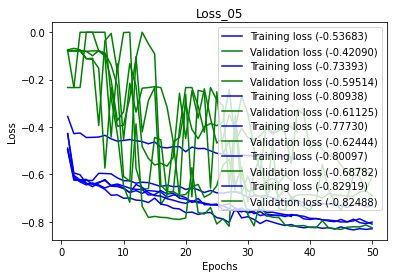

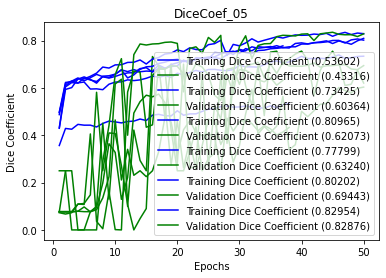

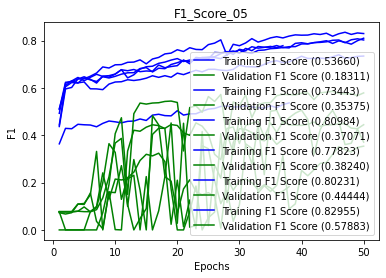

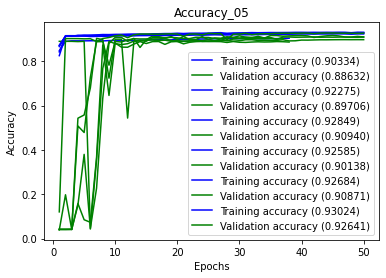

In [8]:
# Prepare EM iterator index.
EM_iterator = 0
dropval = 0.5

print("Target Steps:", EM_target)
print(rebuild_model)

import random

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < EM_target:   
    
    # ---------------------------
    # 0. Initialization
    # ---------------------------
    section_tstamp = time.time()
    section_name = 'EM_Step {:02}'.format(EM_iterator)

    # Create folder for em step
    emfolder = os.path.join(test.dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\n\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    anno_stamp = time.time()
    
    # ---------------------------
    # 1. Creating New Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model (Skip first step since it was pre-generated)
    pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
    p_output = emt.Get_Pmap(train_raster, WinShape, unet_model, pmap_fp)
    
    print("\nGenerated Probability Output Map from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    # 1.2 Weight Candidate Frames
    newSegments = []
    for frame in candidateFrames:
        
        # Get Candidate Weights
        weightedFrame = emt.WeightCandidates(p_output, frame)
        
        # Select Likely or Top Candidate 
        if random.uniform(0,1) < random_candidate_chance:
            # Use 'likely' candidate (ENSURE Select_Candidate() FUNCTION IS UPDATED (lib/EMTools.py))
            newSegments.append(emt.Select_Candidate(weightedFrame, 'weight', weight_limit, default_random=default_random))
        else:
            # Use top candidate
            newSegments.append(emt.Top_Candidate(weightedFrame, 'weight', default_random=default_random))
            
            
        
    # 1.3 Convert List of segments to GeoDataFrame
    newSegmentFrame = gpd.GeoDataFrame(geometry=newSegments, crs=candidateFrames[0].crs)
    newSegmentFrame.to_file(os.path.join(emfolder, 'segments_{:02}.shp'.format(EM_iterator)))

    # 1.4 Connect top segments:
    newAnnotation = emt.Connect_Lines(newSegmentFrame, maxRepairDist)
    newAnnotation.to_file(os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator)))

    # 1.5 Save mean precision of this annotation.
    annoPrecision = emt.GDF_Precision(gt_labels, newAnnotation, precisionBuffer)

    
    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    anno_time = time.time() - anno_stamp
    
    # ---------------------------
    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    buff_anno = st.GDF_Buffer(newAnnotation, labelBuffer, flatten=True)
    anno_raster = st.GDF_Rasterize(buff_anno, train_raster)
    
    # 2.2 Read Y_train, Y_val
    Y_train = gt.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = gt.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val - NOTE: set horizontal flip to FALSE from Sultan's Setup
    Y_train = gt.AugmentImages(Y_train, h_flip=False, v_flip=train_v_flip, rotate=train_rotate)
    Y_val = gt.AugmentImages(Y_val, h_flip=False, v_flip=val_v_flip, rotate=val_rotate)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # ---------------------------
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    callbacks = SetCallbacks(emfolder + '/model_{:02}.h5'.format(EM_iterator))
    
    # 3.2 Determine Learning Rate from schedule
    #EM_learningRate = Step_LR_Schedule(learningRate, EM_iterator, EM_target, lr_const)
    EM_learningRate = learningRate #(EM_iterator%2 + 1)*learningRate/2
    if EM_iterator > 5:
        EM_learningRate = learningRateReduced
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learningRate, EM_iterator))
        
    training_stamp = time.time()
    with mirror_strategy.scope():
        unet_model = UNET_7_224(dropout_val = dropval)
        unet_model.compile(optimizer=Adam(lr=EM_learningRate), loss=dice_coef_loss, metrics=metrics)
        TrainData = unet_model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=useShuffle, batch_size=batchSize, epochs=epochs, callbacks=callbacks)
    training_time = time.time() - training_stamp
    
    training_metrics = {
        'f1': Get_Metric_Data(TrainData, 'f1_score'),
        'dice_coef': Get_Metric_Data(TrainData, 'dice_coef'),
        'loss': Get_Metric_Data(TrainData, 'loss')
    }

    train_metrics_fp = os.path.join(emfolder, 'train_curve_{:02}.csv'.format(EM_iterator))
    with open(train_metrics_fp, 'a+', newline='\n') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter= ',')
        for key, data in training_metrics.items():
            csvwriter.writerow(['Training {}'.format(key)])
            csvwriter.writerow(data)
            
    validation_metrics = {
        'f1': Get_Metric_Data(TrainData, 'val_f1_score'),
        'dice_coef': Get_Metric_Data(TrainData, 'val_dice_coef'),
        'loss': Get_Metric_Data(TrainData, 'val_loss')
    }   
    val_metrics_fp = os.path.join(emfolder, 'val_curve_{:02}.csv'.format(EM_iterator))
    with open(val_metrics_fp, 'a+', newline='\n') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter= ',')
        for key, data in training_metrics.items():
            csvwriter.writerow(['Validation {}'.format(key)])
            csvwriter.writerow(data)
    
    SaveHistory(TrainData, os.path.join(emfolder, 'trainingResults_{:02}'.format(EM_iterator)), test.end) # Save Plots
    
    print("\nCompleted UNet Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # ---------------------------
    # 4. Evaluate Model
    # ---------------------------

    
    # Training Results
    train_results = emt.Evaluate(X_train, Y_train, unet_model)
    # Validation Results
    val_results = emt.Evaluate(X_val, Y_val, unet_model)
    # Testing Results
    test_results = emt.Evaluate(X_test, Y_test, unet_model)

    
    
    # print
    print("\nCompleted Unet Evaluation. (Step {:02})".format(EM_iterator))
    print("\nTraining Results (Step {:02}):".format(EM_iterator))
    print("- {}".format(train_results[0]))
    print("- {}".format(train_results[1]))
    print("\nValidation Results (Step {:02}):".format(EM_iterator))
    print("- {}".format(val_results[0]))
    print("- {}".format(val_results[1]))   
    print("\nTesting Results (Step {:02}):".format(EM_iterator))
    print("- {}".format(test_results[0]))
    print("- {}".format(test_results[1]))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    y_pred=np.copy(unet_model.predict(X_test))
    y_pred = np.round(y_pred)
    y_true=np.copy(Y_test)
    y_pred.shape = y_pred.shape[0]* y_pred.shape[1]*y_pred.shape[2]* y_pred.shape[3]
    y_true.shape = y_true.shape[0]* y_true.shape[1]*y_true.shape[2]* y_true.shape[3]

    c_matrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
    print("confusion_unet", c_matrix)
    report_unet = classification_report(y_true, y_pred)
    print("report_unet", report_unet)
    
    # ---------------------------
    # 5. Save Step Data
    # ---------------------------
    
    # Save to dict for seperate CSV
    dataMatrix['precision'].append(annoPrecision*100)
    dataMatrix['trainDice'].append(train_results[0]) 
    dataMatrix['trainF1Score'].append(train_results[1]) 
    dataMatrix['valDice'].append(val_results[0]) 
    dataMatrix['valF1Score'].append(val_results[1]) 
    dataMatrix['testDice'].append(test_results[0]) 
    dataMatrix['testF1Score'].append(test_results[1]) 
    
    
    # Save EM Step Data 
    test.Results("EM Data {:02}".format(EM_iterator), {
            
        'Time Elapsed: Re-training': training_time,
        'Time Elapsed: New Annotation': anno_time,
            
        'Precision': '{:.2f}%'.format(annoPrecision*100),
        'SourceDelta': '{:.2f}%'.format((annoPrecision-sourcePrecision)*100),
        'StepDelta': '{:.2f}%'.format((annoPrecision-prevPrecision)*100),
        
        'UNet: LR': str(EM_learningRate),
        'UNet: Epochs': str(len(TrainData.history['dice_coef'])),
        
        'UNet: Training Results': train_results,
        'UNet: Validation Results': val_results,
        'UNet: Testing Results': test_results,
        'UNet: Confusion Matrix': c_matrix,
        'UNet: Report': report_unet
    })
    # Save as section
    section_data = {'time': time.time()-section_tstamp, 'stamp': section_tstamp}
    test.Section(section_name, section_data)
    
    # Print step data
    print("\n{} ({:02}) Complete.".format(section_name, len(test.sectionNames)))
    print('- Precision: {:.2f}%'.format(annoPrecision*100))
    print('- SourceDelta: {:.2f}%'.format((annoPrecision-sourcePrecision)*100))
    print('- StepDelta: {:.2f}%'.format((annoPrecision-prevPrecision)*100))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prevPrecision = annoPrecision
 

### Save Test Data 

In [9]:
""" Save EM step data to csv
with open(os.path.join(test.dir, 'EM_Data.csv'), 'a+', newline='\n') as csvfile:
    csvwriter = csv.writer(csvfile, delimiter= ',')
    csvwriter.writerow([test.name, 'Line Precisions (delta)', 'Train Dice Coef (delta)', 'Train F1 Score (delta)', 'Val Dice Coef (delta)', 'Val F1 Score (delta)', 'Test Dice Coef (delta)', 'Test F1 Score (delta)'])
    for i in range(len(dataMatrix['precision'])):
        row = ['step {:02}'.format(i)]
        for key, item in dataMatrix.items():
            row.append('{} ({})'.format(item[i], item[i]-item[0]))
        csvwriter.writerow(row)
"""

# Index test in master csv
test.index()

# Write test Info to Markdown
test.markdown()

# Print Completion
print("Data successfully saved to markdown file, indexed on csv.") 
print(dt.now().strftime('%a at %I:%M:%S%p'))


Data successfully saved to markdown file, indexed on csv.
Thu at 11:44:27AM
